# Weird Behavior Data Exploration

CapsLock
WPM
Error Rate
NegUD
NegUU
RSA
RSB
LSA
LSB
Copy 
Paste
Cut

# 3 sessions - same keyboard


In [152]:
import pandas as pd
from model_weird_behavior.import_data import parse_input_data
from model_weird_behavior.calculate_features import KeystrokeFeatureExtractor
from model_weird_behavior.process_data import split_df_by_user, extract_features_from_groups
import os
import glob
import string
import seaborn as sns
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [153]:


def read_baseline_files_to_dataframes(root_path):
    baseline_dataframes = {}
    for session in ['s0', 's1', 's2']:
        session_path = os.path.join(root_path, session, 'baseline')
        if os.path.exists(session_path):
            files = glob.glob(os.path.join(session_path, '*1.txt'))
            for file in files:
                df = parse_input_data(file)
                df['session'] = session
                file_name = os.path.basename(file)
                df['user_id'] = int(file_name[:3])
                df['keyboard'] = file_name[4]
                file_name = os.path.basename(file)
                baseline_dataframes[f"{session}_{file_name}"] = df
    return baseline_dataframes

# Usage example:
root_path = "/Users/kimkraunz/Library/CloudStorage/GoogleDrive-kim@mimoto.ai/Shared drives/ML/data/public_data/keystrokes/UB_keystroke_dataset"
dataframes = read_baseline_files_to_dataframes(root_path)

In [154]:
# Assuming you have a dictionary of dataframes called 'dataframes'
df = pd.concat(dataframes.values())
df = df.loc[df['session']== 's0']

In [155]:
df.groupby(['session', 'user_id']).size().reset_index(name='count')

,session,user_id,count
0,s0,1,6108
1,s0,2,3912
2,s0,3,4916
3,s0,4,3933
4,s0,5,3784
...,...,...,...
70,s0,71,1830
71,s0,72,3306
72,s0,73,4666
73,s0,74,4468


In [156]:
alpha_numeric_keys = list(string.ascii_lowercase + string.ascii_uppercase + string.digits)
df['key'] = df['key'].apply(lambda x: 'NumPad' if 'NumPad' in x else x)

key_counts = df.groupby('key').size().reset_index(name='count').sort_values(by="count", ascending=False)
key_counts = key_counts.loc[~key_counts['key'].isin(alpha_numeric_keys)]
key_counts = key_counts[~key_counts['key'].str.startswith('Oem', na=False)]
key_counts = key_counts[~key_counts['key'].isin(['Space', 'Return'])]
key_counts = key_counts[~key_counts['key'].str.startswith('D')]

keys_to_get = key_counts['key'].tolist()

In [157]:
key_counts

,key,count
3,Back,22786
36,LShiftKey,4832
37,Left,2026
60,Right,1832
34,LControlKey,854
57,RShiftKey,791
5,Capital,664
64,Tab,646
35,LMenu,308
66,Up,254


In [158]:
main_keys = keys_to_get[:10]
main_keys


['Back',
 'LShiftKey',
 'Left',
 'Right',
 'LControlKey',
 'RShiftKey',
 'Capital',
 'Tab',
 'LMenu',
 'Up']

In [159]:
small_df = df.loc[(df['user_id'] <= 20) & (df['session'] == 's0') & (df['action'] == 'KeyDown') & (df['key'].isin(main_keys))]
# Group by user_id and key, then count
grouped = small_df.groupby(['user_id', 'key']).size().reset_index(name='count')

# Calculate total keystrokes per user
user_totals = df.groupby('user_id').size().reset_index(name='total')

# Merge the totals back to the grouped data
result = pd.merge(grouped, user_totals, on='user_id')

# Calculate relative frequency
result['relative_frequency'] = result['count'] / result['total']

# Sort the results
result = result.sort_values(['user_id', 'relative_frequency'], ascending=[True, False])


result


,user_id,key,count,total,relative_frequency
0,1,Back,362,6108,0.059267
3,1,LShiftKey,80,6108,0.013098
6,1,Tab,22,6108,0.003602
5,1,Right,20,6108,0.003274
2,1,LMenu,18,6108,0.002947
...,...,...,...,...,...
122,20,Back,101,2984,0.033847
123,20,Capital,80,2984,0.026810
124,20,LControlKey,3,2984,0.001005
126,20,Right,3,2984,0.001005


In [ ]:
user_totals

,user_id,total
0,1,6108
1,2,3912
2,3,4916
3,4,3933
4,5,3784
...,...,...
70,71,1830
71,72,3306
72,73,4666
73,74,4468


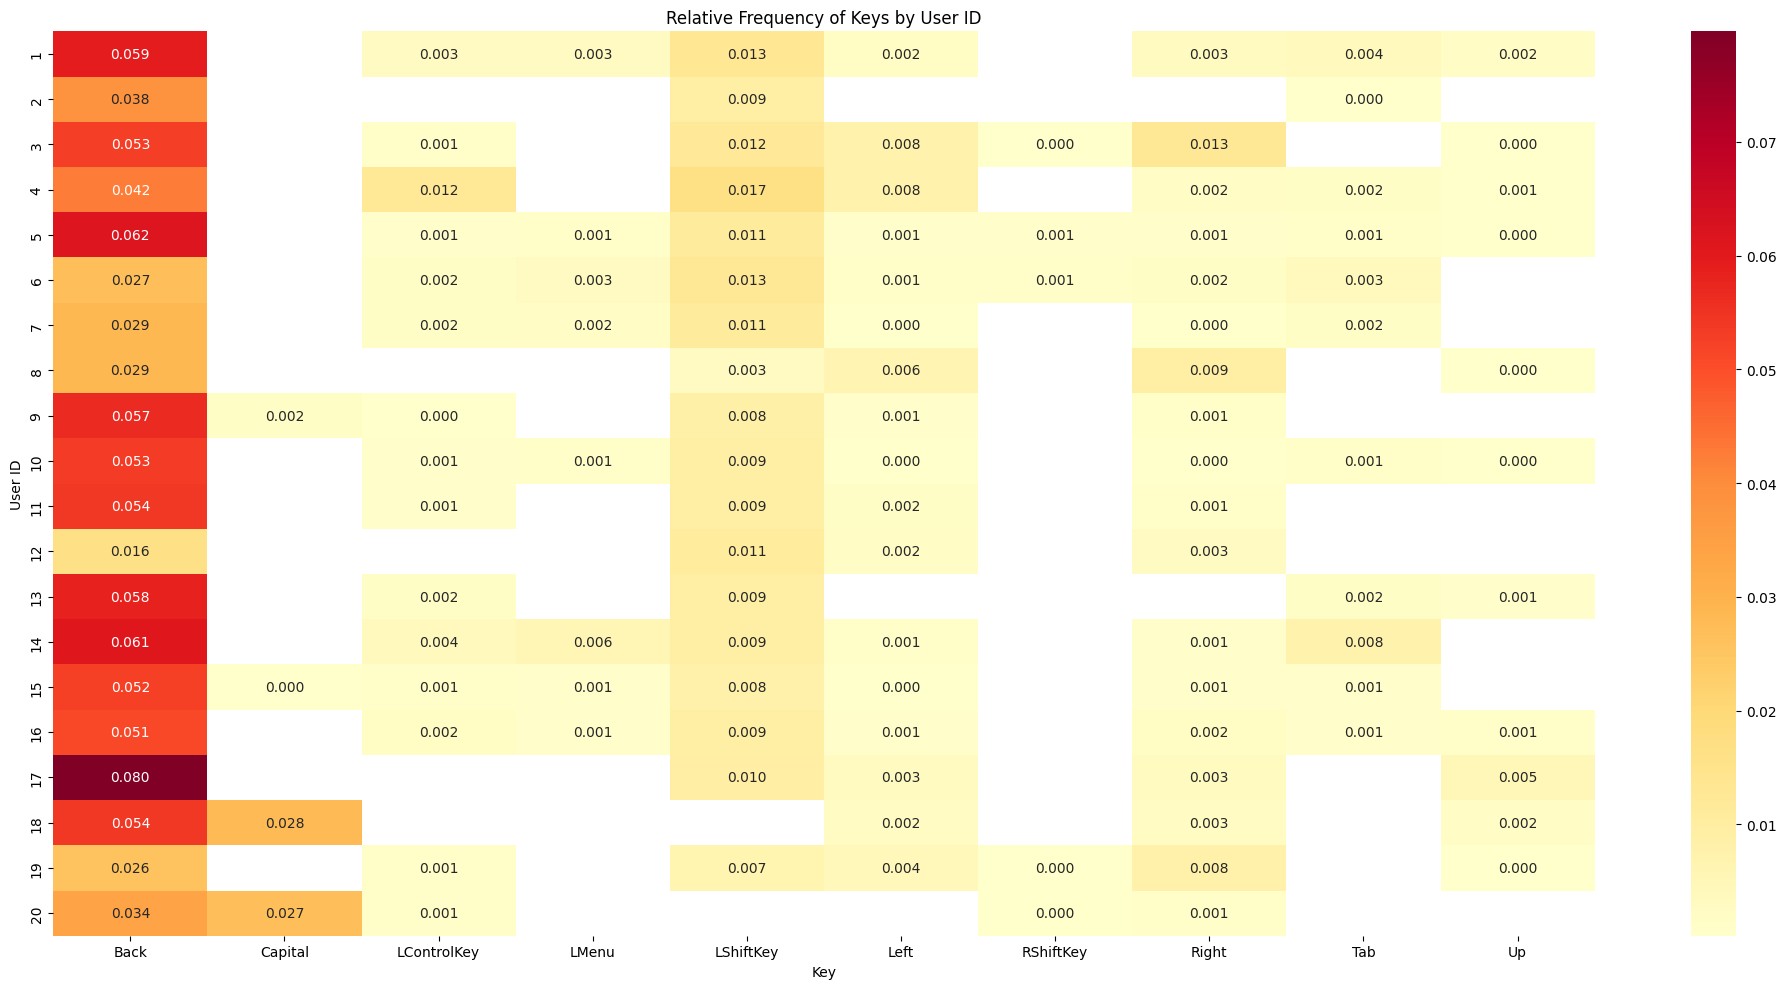

In [ ]:


# Pivot the data to create a matrix suitable for a heatmap
heatmap_data = result.pivot(index='user_id', columns='key', values='relative_frequency')

# Create the heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(heatmap_data, annot=True, cmap='YlOrRd', fmt='.3f')

# Customize the plot
plt.title('Relative Frequency of Keys by User ID')
plt.xlabel('Key')
plt.ylabel('User ID')

# Adjust layout and display
plt.tight_layout()
plt.show()

In [ ]:
heatmap_data

key,Back,Capital,LControlKey,LMenu,LShiftKey,Left,RShiftKey,Right,Tab,Up
user_id,,,,,,,,,,
1,0.059267,NaN,0.002783,0.002947,0.013098,0.002128,NaN,0.003274,0.003602,0.001801
2,0.038344,NaN,NaN,NaN,0.009458,NaN,NaN,NaN,0.000256,NaN
3,0.052889,NaN,0.001017,NaN,0.012205,0.007526,0.000203,0.012815,NaN,0.000203
4,0.042461,NaN,0.012459,NaN,0.016527,0.007628,NaN,0.001780,0.001526,0.000509
5,0.061575,NaN,0.000529,0.001057,0.011364,0.000529,0.000793,0.000529,0.001321,0.000264
6,0.026724,NaN,0.001724,0.002874,0.012931,0.000862,0.000862,0.001724,0.003448,NaN
7,0.028717,NaN,0.001610,0.001879,0.011272,0.000268,NaN,0.000268,0.001610,NaN
8,0.028618,NaN,NaN,NaN,0.002726,0.006269,NaN,0.009267,NaN,0.000273
9,0.056647,0.001754,0.000351,NaN,0.008418,0.000702,NaN,0.000877,NaN,NaN


In [ ]:
user_totals.sort_values(by="total", ascending=False)

,user_id,total
50,51,6662
61,62,6478
0,1,6108
16,17,6059
8,9,5702
...,...,...
48,49,2506
41,42,2452
59,60,2214
28,29,1998


In [ ]:
df_splits = split_df_by_user(df, n_groups=6, group_length=1000)

In [ ]:
results = extract_features_from_groups(df_splits)

Processed 100 groups
Processed 200 groups
Processed 300 groups
Processed 400 groups


In [ ]:
cols = list(results[0].keys())

features_list = []
for result in results:

# pd.DataFrame.from_dict(results[0], orient='index', columns=cols)
    features = pd.DataFrame.from_dict([result])
    features_list.append(features)

data = pd.concat(features_list, ignore_index=True)

In [ ]:
data.dropna(inplace=True)

In [ ]:
data_smaller = data.loc[data["user_id"] <= 10]

In [ ]:
X = data_smaller.drop(columns=["user_id", "interval"])

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=2))])


pca_data = pd.DataFrame(pipeline.fit_transform(X), columns = ['PC1', 'PC2']) 
pca_data['user_id'] = data_smaller['user_id'].astype(str).to_list()


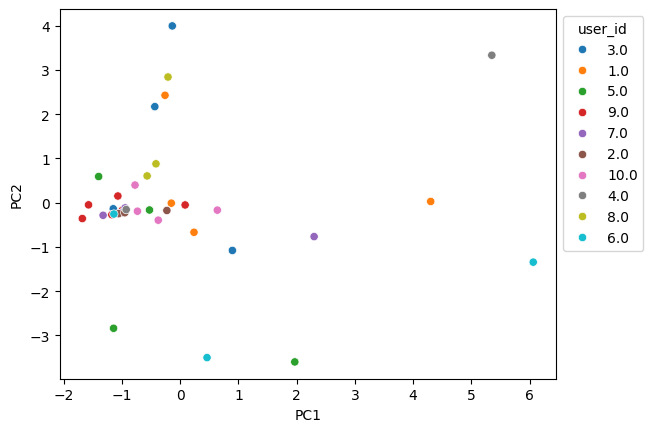

In [ ]:
ax=sns.scatterplot(x="PC1", y="PC2", data=pca_data, hue='user_id')
# sns.scatterplot(x="PC1", y="PC2", data=pca_data)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))